# 1. Data Load


In [1]:
import numpy as np
import pandas as pd
import math

from scipy import stats #Analysis 
from scipy.stats import norm 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [2]:
# 한글 폰트가 깨지면 실행하세요! 
import matplotlib.font_manager as fm
fontlist = fm.findSystemFonts(fontpaths = None, fontext='ttf')
# 아래 주석을 지워서 폰트 리스트를 확인하고 한글 폰트를 font_path에 추가합니다
fontlist[:]

from matplotlib import font_manager, rc
#font_path = 'C:\\Users\\mtang\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquare.ttf'
font_path = 'C:\\WINDOWS\\Fonts\\NanumGothicLight.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [3]:
path = "./Dataset/"

data = pd.read_csv(path+"kwproja_data_big.csv")

# original data -> data
data

,date,shop_code,shop_name,shop_type_big,shop_type_small,longitude,latitude,monthly_gain,average_sale_price
0,201709,24432350113,친쿡부대찌개 오류동본점,뷔페,고기 뷔페,126.844998,37.496882,12881013.37,21514
1,201709,13141330215,드럼통집,뷔페,고기 뷔페,127.096574,37.505706,33931612.72,52264
2,201706,39421720107,하우돈,뷔페,고기 뷔페,126.906290,37.518280,21456513.16,42656
3,201706,4602500509,고고생고기,뷔페,고기 뷔페,127.109240,37.501153,6140707.30,34561
4,201709,39313780106,현대식당,뷔페,고기 뷔페,126.980601,37.518535,6091482.50,38423
...,...,...,...,...,...,...,...,...,...
2927734,201803,66340980106,최가네 남원추어탕,수산물,회/수산물 일반,126.963825,37.526863,13693767.90,21511
2927735,201803,7211800169,우미도라꾸,수산물,회/수산물 일반,127.070132,37.536551,17432801.29,74559
2927736,201804,7408500552,연안해물칼국수 행당점,수산물,회/수산물 일반,127.033712,37.559118,17023101.74,34212
2927737,201803,36412610212,동해수산,수산물,회/수산물 일반,127.127448,37.537151,31533908.77,52973


# EDA 

2,927,739 rows X 9 columns

- 매장 속성 정보
  - shop_code -> 식별자 feature, input feature로는 사용하지 않지만 분류를 위해서는 사용할 수 있을 것 같음  
  - shop_name -> input feature로는 사용하지 않음 (NLP deep learning 가능성 있음)
  - longtitude : 경도, latitude : 위도 -> 매장 위치 (회사 근처, 학교 근처 등 매출 영향성 있음) -> 군집화, labeling 필요
  - shop_type_big -> 15 category  -> 업종 (매출 영향성 있음)
  - shop_type_small -> 61 category

- 매출 정보
  - date -> 24 category, 201606~ 201805 까지의 data
  - monthly_gain / avearge_sale_price = 한달 총 판매수

- 매출 통계 정보-> X


##### monthly_gain과 average_sale_price 중 어느 것을 y값으로 둘 것인가? 
- 월매출 예측 문제로 가정하고 montly_gain 을 y값으로 예측하는 모델 만들기

##### shop_code는 input feature에 넣어야 하는가?
- 특별한 브랜드가 y값을 결정하는 과적합 요소가 될 수 있으므로
- X 에서 shop code, shop name 제외하는 것도 방법
- 어느 위치에 어떤 업종으로 어떤 객단가인 매장을 오픈하면 월매출이 어떻게 될까? 문제
 - X: shop type big, shop type small, longitude, latitude, avg_sale_price, 
 - y: montly_gain

In [4]:
data.columns

Index(['date', 'shop_code', 'shop_name', 'shop_type_big', 'shop_type_small',
       'longitude', 'latitude', 'monthly_gain', 'average_sale_price'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2927739 entries, 0 to 2927738
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                int64  
 1   shop_code           int64  
 2   shop_name           object 
 3   shop_type_big       object 
 4   shop_type_small     object 
 5   longitude           float64
 6   latitude            float64
 7   monthly_gain        float64
 8   average_sale_price  int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 201.0+ MB


# 3. Preprocessing
- missing value 제거 
    - monthly_gain : 3,605 제거 -> 149,790
    - shop_type_big : 4,303 제거 -> 145,487 
    - gender feature : 1,187 제거 -> 144,300
- shop_code, shop_name : 식별자 feature 이므로 drop 
- date : 아직은 쓸 수 없으므로 drop
    - 여기까지 총 144,300 X 27
- shop_type_big(13), shop_type_small(367) : label encodding
- longitude, latitude : clustering을 통해 labeling 후 해당 두 열은 drop 
- MinMaxSaclar 정규화 -> 정규화 column의 범위는??

In [48]:
# 원본 data와 따로 관리 -> original data = data, input data = input_data 
# feature drop
input_data = data.copy()
input_data = input_data.drop(['date', 'shop_code'], axis=1)

In [49]:
# There are no missing values 
# missing value drop - monthly_gain
null_index = input_data[input_data['monthly_gain']==0].index 
print("monthly gain null : ", len(null_index))
input_data = input_data.drop(null_index)

# missing value drop - shop_type_big
null_index = input_data[input_data['shop_type_big'].isnull()==True].index
input_data = input_data.drop(null_index)

# missing value drop - shop_type_small 
print("shop type big null : ", len(input_data['shop_type_small'].unique()))
print("shop type small null : " , input_data['shop_type_small'].isnull().value_counts())

monthly gain null :  0
shop type big null :  61
shop type small null :  False    2927739
Name: shop_type_small, dtype: int64


In [50]:
# LabelEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
input_data['shop_type_big'] = le.fit_transform(list(input_data['shop_type_big']))   # fit transform으로 한번에 처리 가능
print(le.classes_)

le = LabelEncoder()
input_data['shop_type_small'] = le.fit_transform(list(input_data['shop_type_small'])) 
print(le.classes_)

['다방/커피숍/카페' '별식/퓨전요리' '분식' '뷔페' '생활서비스' '소매' '수산물' '양식' '유흥주점' '음식-미분류'
 '일식' '제과제빵떡케익' '중식' '패스트푸드' '한식']
['고기 뷔페' '고기구이/육회 전문점' '곱창/양구이 전문점' '구내식당' '국수/수제비 전문점' '기타세계요리 전문점'
 '낙지/문어/오징어/쭈꾸미 전문점' '냉면 전문점' '덮밥/가정식' '도너츠/꽈배기/고로케/호떡 전문점'
 '도시락/컵밥/주먹밥/배달음식 전문점' '돈가스 전문점' '떡/한과 전문점' '마라/양꼬치/훠궈 전문점' '면 전문점'
 '미분류 유흥업소' '민속주점' '바닷가재/게요리 전문점' '반찬 판매' '백화점' '버거 전문점' '베트남음식 전문점'
 '보쌈/족발 전문점' '분식 전문점' '샌드위치/토스트/핫도그 전문점' '샤브샤브 전문점' '세탁소' '소주방/포장마차'
 '순대 전문점' '슈퍼/잡화/할인매장' '스테이크 전문점' '식료품' '아이스크림/빙수 판매' '오리/닭요리 전문점'
 '오리/닭요리/탕/백숙 전문점' '와인/칵테일/위스키 바' '음식-미분류' '이자까야/꼬치구이' '이태리 전문점'
 '인도음식 전문점' '일반 중식당' '장어 전문점' '전통찻집' '제과/제빵 전문점' '조개 전문점' '종합 뷔페'
 '죽요리 전문점' '참치 전문점' '초밥 전문점' '치킨/닭강정 전문점' '카레 전문점' '카페/디저트' '테이크아웃 음료 전문점'
 '편의점' '퓨전음식 전문점' '피자 전문점' '한식국물요리 전문점' '한정식/백반 전문점' '호프/맥주' '화로구이 전문점'
 '회/수산물 일반']


[[ 37.53984087 126.84569152]
 [ 37.50145315 127.0345484 ]
 [ 37.56626276 126.99486387]
 [ 37.49490469 126.89669107]
 [ 37.51701103 127.12120976]
 [ 37.57393582 126.92468323]
 [ 37.49664916 126.95211677]
 [ 37.63893398 127.04530643]
 [ 37.57059473 127.0680711 ]]
[0 4 3 ... 8 4 3]


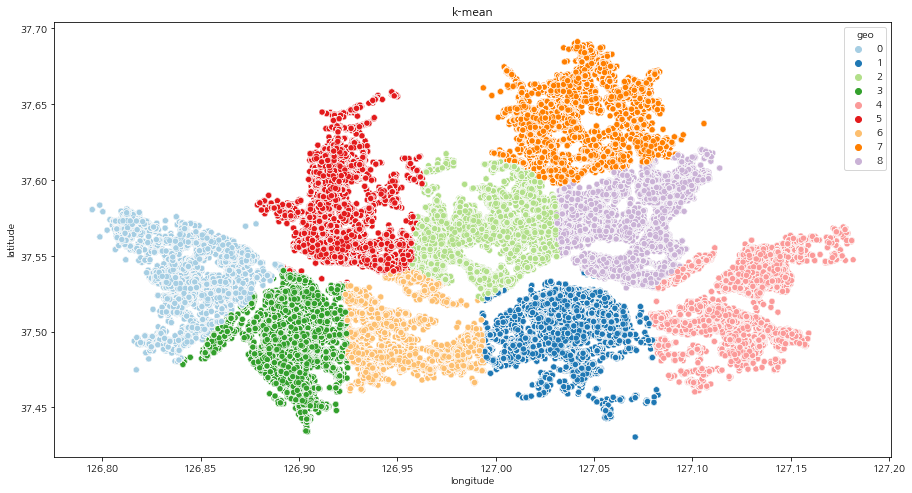

In [51]:
# Labeling - KMeans Clustering 
# longitude + latitude = geo 
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=9).fit(input_data[['latitude', 'longitude']])
print(kmeans.cluster_centers_)
print(kmeans.labels_)

# longitude + latitude = geo 
# So we get inpute_data = 2,927,739 rows × 5 columns
input_data['geo'] = kmeans.labels_

sns.scatterplot(x='longitude' , y='latitude', hue="geo", data=input_data, palette="Paired")
plt.title('k-mean')

input_data = input_data.drop(['longitude', 'latitude'], axis=1)

In [52]:
# average_sale_price -> skewed 된 feature 
# log정규화 
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, Normalizer

scale_cols = ['average_sale_price']

for c in scale_cols : 
    scaled_data = pd.DataFrame(np.log1p(input_data[c]))
    input_data[c] = scaled_data

input_data

,shop_name,shop_type_big,shop_type_small,monthly_gain,average_sale_price,geo
0,친쿡부대찌개 오류동본점,3,0,12881013.37,9.976506,0
1,드럼통집,3,0,33931612.72,10.864082,4
2,하우돈,3,0,21456513.16,10.660947,3
3,고고생고기,3,0,6140707.30,10.450510,4
4,현대식당,3,0,6091482.50,10.556438,6
...,...,...,...,...,...,...
2927734,최가네 남원추어탕,6,60,13693767.90,9.976366,6
2927735,우미도라꾸,6,60,17432801.29,11.219359,8
2927736,연안해물칼국수 행당점,6,60,17023101.74,10.440361,8
2927737,동해수산,6,60,31533908.77,10.877557,4


<AxesSubplot:xlabel='shop_type_big', ylabel='average_sale_price'>

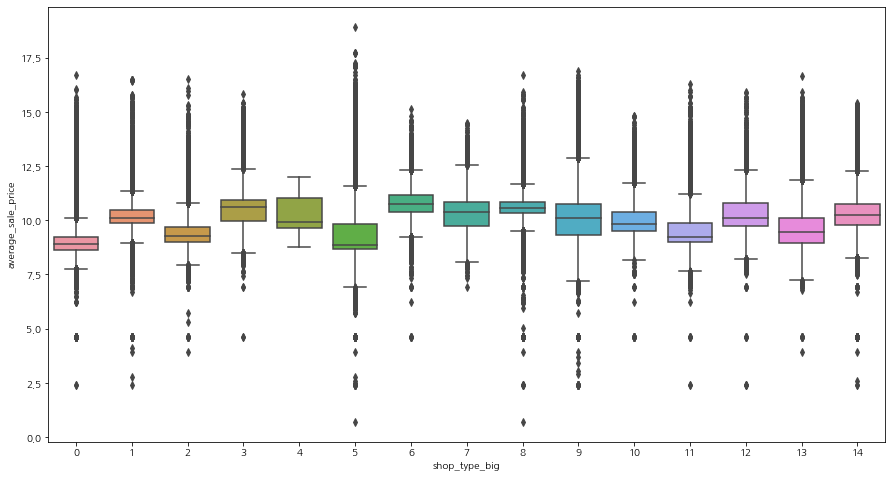

In [53]:
# check the preprocessed 'average_sale_price' by shop_type_big
rcParams['figure.figsize'] = 15,8
sns.boxplot(x='shop_type_big', y='average_sale_price', data=input_data)

<AxesSubplot:title={'center':'monthly_gain'}, xlabel='[shop_type_big]'>

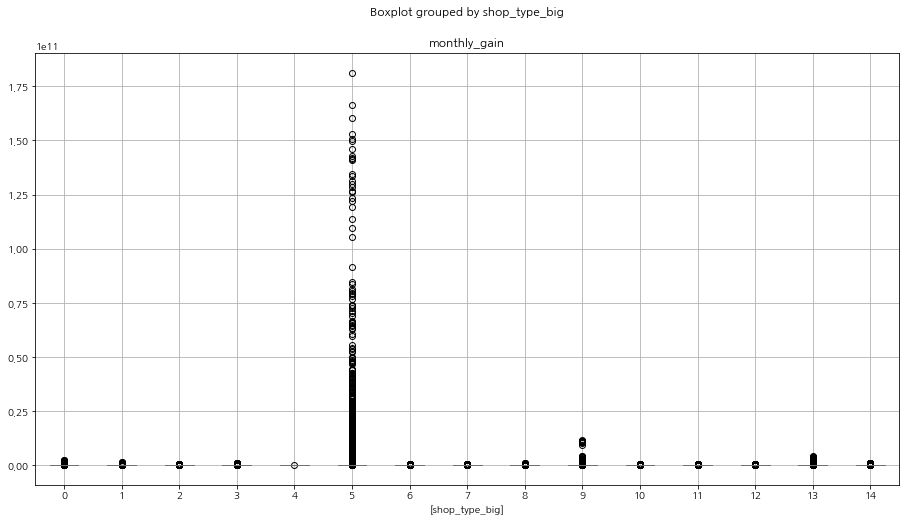

In [54]:
# check the 'monthly_gain'
input_data.boxplot(column = ['monthly_gain'], by=['shop_type_big'])

# 5. Target Variable Labeling and EDA for variable y
### 어떻게 라벨링 할 것인가?
- 원래 가격대에 대한 정보(price_dict)는 계속 가져가야 함! 

In [55]:
# pandas option 설정 하는 코드
# monthly_gain의 경우 부동소수점으로 나타나서 보기 어려울땐 윗 줄의 주석을 제거하고 아래에 주석을 추가하고
# 다시 원래대로 돌리고 싶다면 아래에 주석제거, 위 코드에 주석추가
pd.options.display.float_format = '{:.2f}'.format
#pd.reset_option('display.float_format')

input_data.head()

,shop_name,shop_type_big,shop_type_small,monthly_gain,average_sale_price,geo
0,친쿡부대찌개 오류동본점,3,0,12881013.37,9.98,0
1,드럼통집,3,0,33931612.72,10.86,4
2,하우돈,3,0,21456513.16,10.66,3
3,고고생고기,3,0,6140707.30,10.45,4
4,현대식당,3,0,6091482.50,10.56,6


In [56]:
group_big_gain = input_data[['shop_type_big','monthly_gain']].groupby('shop_type_big')
df_group_big_gain = group_big_gain.describe().droplevel(axis=1,level=0)

# monthly_gain을 shop_type_big 분야별로 정렬하여 출력
print("내림차순 기준 분야별로 정렬하여 출력합니다 - monthly_gain")
print("min: ", list(df_group_big_gain.sort_values(by=['min'], ascending=False).index))
print("mean:", list(df_group_big_gain.sort_values(by=['mean'], ascending=False).index))
print("max: ", list(df_group_big_gain.sort_values(by=['max'], ascending=False).index))

df_group_big_gain

내림차순 기준 분야별로 정렬하여 출력합니다 - monthly_gain
min:  [4, 7, 3, 6, 10, 2, 13, 11, 14, 0, 1, 9, 12, 8, 5]
mean: [5, 3, 12, 6, 7, 10, 14, 13, 11, 9, 1, 8, 2, 0, 4]
max:  [5, 9, 13, 0, 1, 14, 8, 3, 12, 10, 6, 11, 2, 7, 4]


,count,mean,std,min,25%,50%,75%,max
shop_type_big,,,,,,,,
0,318339.00,13632884.54,26295553.89,50.08,3252624.81,7505698.33,15909550.27,2454380350.60
1,213619.00,19719527.02,28706052.33,49.63,5770587.82,12058130.24,23826346.30,1535740006.14
2,188263.00,15053556.30,19543045.12,253.05,3471252.46,8711467.56,19694451.96,594568831.67
3,24891.00,36001109.95,70222881.23,503.42,6552622.10,15851043.88,36195659.42,1246631436.93
4,47.00,4971385.58,3441529.09,31102.45,2922138.00,4186328.34,6760663.68,15394364.73
5,359034.00,116397419.86,1569075536.95,5.06,7382320.10,27178602.55,47733778.69,181237335603.49
6,131323.00,28338011.74,33013325.12,493.80,8455953.14,18101518.61,36318652.47,703395339.57
7,13726.00,25495120.25,38188710.77,5593.31,6093858.38,13859828.04,28725833.43,550879240.77
8,254766.00,15803340.87,22753249.79,5.55,3687630.29,9033763.00,19227524.34,1289820781.86


Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], dtype='int64', name='shop_type_big')


<AxesSubplot:xlabel='shop_type_big'>

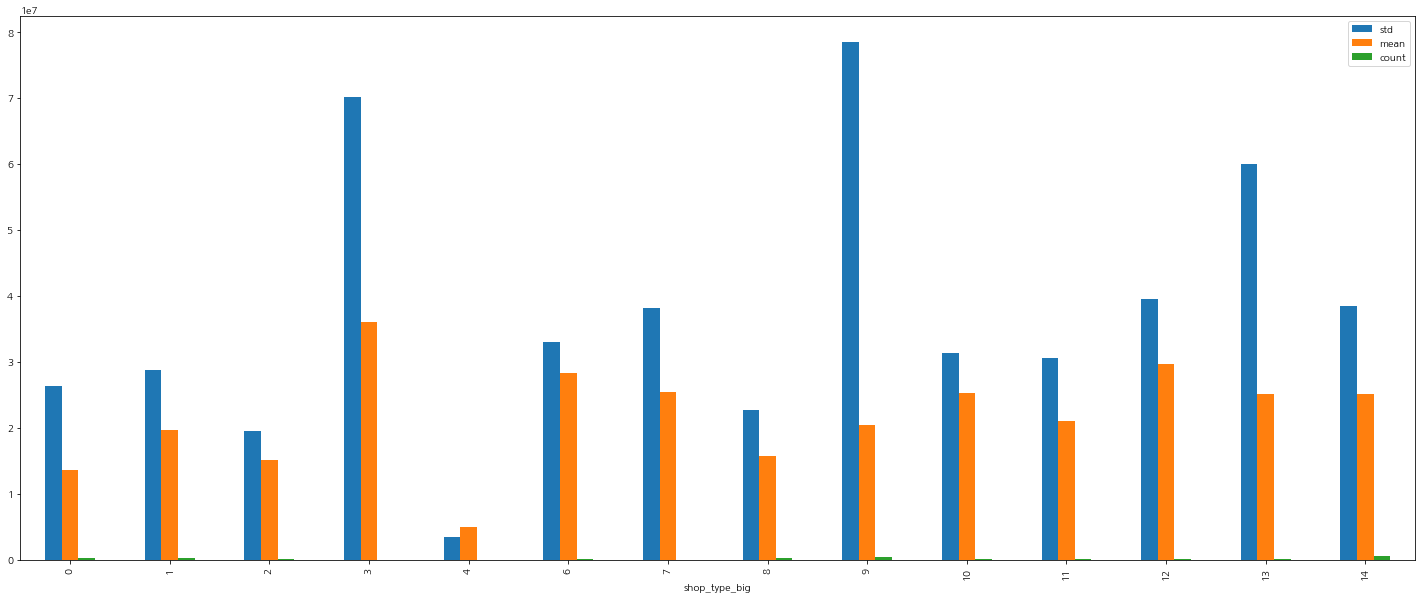

In [57]:
# shop_type_big 으로 묶은 후 shop_type_small 간의 평균 가격대를 비교하는 코드 
# 제조같은 분야는 하나의 소분야가 압도적으로 가격대가 높게 형성되어 있고 나머지는 비슷비슷함
# 스포츠 같은 경우는 모든 소분야가 비슷한 가격대를 형성함 

# shop_type_big 중에서 5번 종목이 가격 분포가 너무 넓어서 그래프를 그렸을 때 다른 종목도 보기 어려워서
# 5번을 드랍하고 보기로 함 -> 전반적으로 평균보다 편차가 훨씬 큼
typebig_list = df_group_big_gain.index
print(typebig_list)

updated_df = df_group_big_gain.drop(5).copy()
updated_df.plot.bar(y=['std', 'mean', 'count'], figsize=(25,10))

<AxesSubplot:>

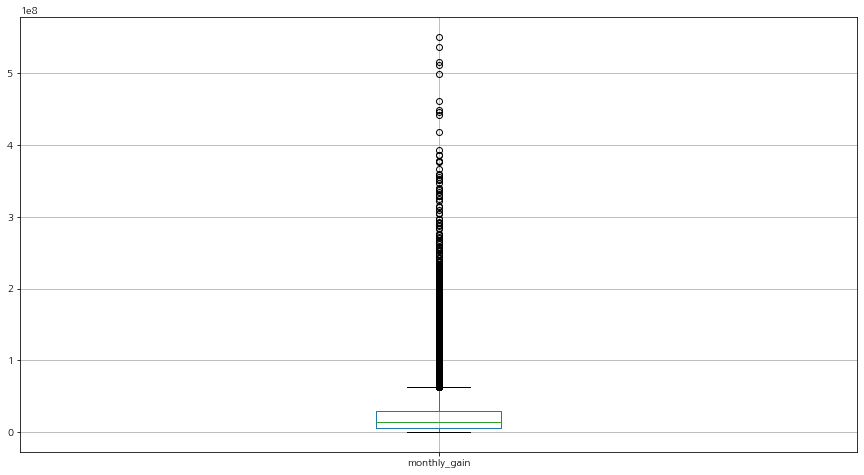

In [58]:
group_big_gain.get_group(7).boxplot(column='monthly_gain')

In [59]:
# box plot 상 outlier와 Quantile 상 75% 이상의 값을 확인합니다
# we detect outlier (from upper, lower) and values greater than 75% in the quantile
list_q4 = df_group_big_gain['75%'].values
for i in range(0, 15) :
    Q1 = group_big_gain.get_group(i)['monthly_gain'].quantile(0.25)
    Q3 = group_big_gain.get_group(i)['monthly_gain'].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - (1.5 * IQR)
    upper_fence = Q3 + (1.5 * IQR)
    
    df = group_big_gain.get_group(i)['monthly_gain']
    print("%.2f \t" % upper_fence, len(df[df > upper_fence]),
          "\t %.2f \t" % lower_fence, len(df[df < lower_fence]),
          "\t %.2f \t" % list_q4[i], len(df[df > list_q4[i]]))

34894938.47 	 25133 	 -15732763.39 	 0 	 15909550.27 	 79585
50909984.01 	 15726 	 -21313049.89 	 0 	 23826346.30 	 53405
44029251.20 	 12003 	 -20863546.78 	 0 	 19694451.96 	 47066
80660215.41 	 2393 	 -37911933.89 	 0 	 36195659.42 	 6223
12518452.19 	 1 	 -2835650.51 	 0 	 6760663.68 	 12
108260966.57 	 26678 	 -53144867.79 	 0 	 47733778.69 	 89759
78112701.48 	 8612 	 -33338095.86 	 0 	 36318652.47 	 32831
62673795.99 	 1188 	 -27854104.18 	 0 	 28725833.43 	 3432
42537365.43 	 19350 	 -19622210.80 	 0 	 19227524.34 	 63692
39939730.58 	 50532 	 -20383615.12 	 0 	 17318475.94 	 113798
65141675.56 	 6064 	 -26237960.82 	 0 	 30874311.91 	 20872
68311513.06 	 5384 	 -35900662.02 	 0 	 29231947.41 	 24550
79422526.81 	 8360 	 -35878457.05 	 0 	 36184657.86 	 28105
60759363.69 	 11580 	 -28081740.76 	 0 	 27443949.52 	 32636
67389789.09 	 40136 	 -31269822.98 	 0 	 30392434.57 	 135972


In [60]:
# Explore shop_type_small

#df_typesmall = []
#for _ in typebig_list :
#    df = df_check[df_check['shop_type_big'] == _ ].groupby('shop_type_small').describe().droplevel(axis=1,level=0)
#    df_typesmall.append(df)
#df_typesmall[2].plot.bar(y=['std','mean'], figsize=(25,10))

#### Labeling 1) quantity하게, 백분율을 이용해서

- **Label(10)**  min 10% 20% ... 80% 90% max의 값을 찾은 후, monthly_gain에 대해 두 범위 사이에 존재하는 값에 대해서 평균 값으로 라벨링 합니다. 
    - 예) min 과 10% 사이의 값 -> min과 10%의 평균 값으로 라벨링
    - 라벨링 분포가 정확히 14432~14430 사이로 떨어짐 -> 오로지 백분율로 잘랐기 때문에 분포에 대한 걱정은 안해도 됨
    - accuracy f-1score : 0.50 ~ 0.49
- **Label(3)**  위와 동일한 방식으로 자릅니다. 
    - 0 ~ 33 ~ 66 ~ 99(100) -> 총 3개의 label 생성
    - 1: 3,669,015.0075000003, 2: 18,734,738.491500005, 3: 303,196,624.6690003
    - 3백, 2천(1천8백만), 3억
    - accuracy f-1score : 0.84 ~ 0.82
- **Label(4)**  위와 동일한 방식으로 자릅니다. 
    - 0 ~ 25 ~ 50 ~ 75 ~ 100 -> 총 4개의 label 생성
    - 1: 2,324,858.25, 2: 10,317,593.25, 3: 29,815,219.125, 4: 32,692,544,860.4
    - 2백, 1천만, 3천만(2천9백), 326억
    - accuracy f-1score : 0.78 ~ 0.76
- **Label(5)**  위와 동일한 방식으로 자릅니다. 
    - 0 ~ 20 ~ 40 ~ 60 ~ 80 ~ 100 -> 총 5개의 label 생성
    - 1: 1,622,880.0, 2: 6,773,160.0, 3: 17,044,674.75,4: 39,214,985.75, 5: 32,698,042,967.275
    - 1백만, 6백만, 1천7백만, 4천(3천9백만), 326억
    - accuracy f-1score : 0.71 ~ 0.70
- 백분율로 자르는 방법
    - labe(10)의 경우 유난히 4~8 label에 대해서는 잘 못맞춤 -> monthly_gain을 일렬로 세웠을 때 앞 뒤로 뭉쳐있어서 그런 것 같음 
    - 무작정 quantity하게 값을 나눠서 라벨링 하는 것은 좋은 것 같지 않음..
    - 앞, 뒤로는 자잘하게 자르고 가운데는 큼직하게 잘라야..?
    - 확실히 class의 개수가 많아질수록 accuracy가 낮아짐

In [27]:
price_dict = {}  # original price를 저장하기 위한 dict
price_list = [0] # 시작 min 값은 0 
for i in range(1, 6) :
    price_list.append(input_data['monthly_gain'].quantile(q=i*0.2)) # 10% ~ 100% 값을 가져옵니다    

def labeling(x) : 
    for i in range(1, len(price_list)) :
        price_dict[i] = (price_list[i]+price_list[i-1])/2
        if x < price_list[i] and x >= price_list[i-1] : return i
    return i

input_data['monthly_gain_label'] = input_data.monthly_gain.apply(labeling)
print(input_data['monthly_gain_label'].unique())
print(price_dict)
print(price_list)

[3 5 4 2 1]
{1: 1650675.71, 2: 5705588.994, 3: 12177205.197000002, 4: 24813489.456, 5: 90635358999.288}
[0, 3301351.42, 8109826.568, 16244583.826000005, 33382395.085999995, 181237335603.49]


#### Labeling 2) shop_type_big에 따라 중간값, 편차를 이용

- 모든 업종이 중간값 보다 편차가 너무 커서 폐기

In [30]:
min_dict = df_group_big_gain['min'].to_dict()
mean_dict = df_group_big_gain['mean'].to_dict()
max_dict = df_group_big_gain['max'].to_dict()
std_dict = df_group_big_gain['std'].to_dict()

def labeling(x) : 
    price_dict = []
    for i in range(0, 15) :
        max_price = mean_dict[i] + std_dict[i]
        if mean_dict[i]-std_dict[i] <= 0 : min_price = 0 
        else : min_price = mean_dict[i] - std_dict[i]

        if x <= min  : return min/2
        elif x>= max : return  
    return i

print(price_dict)
input_data['pre_monthly_gain'] = input_data.monthly_gain.apply(labeling)
input_data

{0: 26295553.88916357,
 1: 28706052.331207,
 2: 19543045.119965058,
 3: 70222881.23349647,
 4: 3441529.085336429,
 5: 1569075536.9468012,
 6: 33013325.117963992,
 7: 38188710.77183407,
 8: 22753249.787695788,
 9: 78472248.1300839,
 10: 31280422.831923284,
 11: 30650347.19939113,
 12: 39582896.63406678,
 13: 60055572.84763823,
 14: 38543045.25275931}

#### Labeling 3) shop_type_big에 따라 Q1, Q2, Q3, upper fence, lower fence값 이용  

- shop_type_big 당 label 3개 : Total lable 30 + 1(lower_fence=0) = 31 
- Q1 ~ 이하 값 : lower fence = 0
- Q1 ~ Q3 : Q2, mid
- Q3 ~ 이상 값 : upper fence 

- shop_type_big 당 label 3개 : Total label 45
- Q1 이하값 : Q1 
- Q1 ~ Q3 : Q2, mid
- Q3 이상값 : Q3

In [61]:
def get_pricelist(i) :
    Q1 = group_big_gain.get_group(i)['monthly_gain'].quantile(0.25)
    Q2 = group_big_gain.get_group(i)['monthly_gain'].quantile(0.5)
    Q3 = group_big_gain.get_group(i)['monthly_gain'].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - (1.5 * IQR)
    upper_fence = Q3 + (1.5 * IQR)
    if lower_fence <= 0 : lower_fence = 0
        
    return lower_fence, Q1, Q2, Q3, upper_fence

def labeling() : 
    for i in range(0,15) : 
        lower_fence, Q1, Q2, Q3, upper_fence = get_pricelist(i)
        prices = input_data.loc[(input_data.shop_type_big == i), 'monthly_gain']
        #prices = prices.apply(lambda x: lower_fence if x < Q1 else (upper_fence if x > Q3 else Q2))
        prices = prices.apply(lambda x : Q1 if x < Q1 else (Q3 if x > Q3 else Q2))
        input_data.loc[(input_data.shop_type_big == i), 'monthly_gain_label'] = prices

labeling()
print(input_data['monthly_gain_label'].nunique())
input_data

45


,shop_name,shop_type_big,shop_type_small,monthly_gain,average_sale_price,geo,monthly_gain_label
0,친쿡부대찌개 오류동본점,3,0,12881013.37,9.98,0,15851043.88
1,드럼통집,3,0,33931612.72,10.86,4,15851043.88
2,하우돈,3,0,21456513.16,10.66,3,15851043.88
3,고고생고기,3,0,6140707.30,10.45,4,6552622.10
4,현대식당,3,0,6091482.50,10.56,6,6552622.10
...,...,...,...,...,...,...,...
2927734,최가네 남원추어탕,6,60,13693767.90,9.98,6,18101518.61
2927735,우미도라꾸,6,60,17432801.29,11.22,8,18101518.61
2927736,연안해물칼국수 행당점,6,60,17023101.74,10.44,8,18101518.61
2927737,동해수산,6,60,31533908.77,10.88,4,18101518.61


In [19]:
# upper fence, Q2 값은 모두 백만원대~천만원대(하나만 억대) 이기 때문에
# 십만원대 아래 가격들은 모두 반올림 하여 비슷한 label 값을 가지는 것들은 통일
#input_data[input_data['shop_type_big']==12]['monthly_gain_label'].value_counts()
print(input_data['monthly_gain_label'].nunique())
input_data['monthly_gain_label'] = input_data.monthly_gain_label.apply(lambda x : round(x, -5)
                                                                       if x < 10000000 else round(x, -6))
print("original monthly_gain_label counts : ", input_data['monthly_gain_label'].nunique())
print("rounded monthly_gain_label counts : ", input_data['monthly_gain_label'].value_counts())

SyntaxError: EOL while scanning string literal (Temp/ipykernel_17660/515820054.py, line 7)

#### Labeling 4) all price range
- min : 5 
- max : 181,237,335,603 (181억)
- 10,000원*
- 100,000원(십만원대)*
- 500,000원(십만~오십만원대)*
- 1,000,000원 (백만원대)
- 2, 3, 4, 5, 6, 7, 8, 9 (detailed)
- 10,000,000원 (천만원대)
- 30,000,000원 
- 50,000,000원
- 70,000,000원
- 100,000,000원 (억대)*
- 500,000,000원 *
- 1,000,000,000원(십억대) *
- 10,000,000,000원(백억대) *

In [132]:
price_dict = [10000, 100000,
              1000000, 3000000, 5000000, 7000000,
              10000000, 30000000, 50000000, 70000000,
              100000000, 500000000, 1000000000, 10000000000, 15000000000]
print(len(price_dict))

def labeling(x) : 
    for i in range(0, len(price_dict)) :
        if x < price_dict[i] : return price_dict[i]
    return price_dict[-1]

input_data['monthly_gain_label'] = input_data.monthly_gain.apply(labeling)
print(input_data['monthly_gain_label'].value_counts())

15
30000000       921620
3000000        343299
50000000       343069
5000000        284585
10000000       281385
7000000        235054
1000000        177939
70000000       144192
500000000       87076
100000000       83310
100000          16747
1000000000       4815
10000000000      3177
10000             805
15000000000       666
Name: monthly_gain_label, dtype: int64


#### Labeling 5) without outlier
upper fence, lower fence 외 값(outlier)을 제거합니다 

In [62]:
def get_pricelist(i) :
    Q1 = group_big_gain.get_group(i)['monthly_gain'].quantile(0.25)
    Q2 = group_big_gain.get_group(i)['monthly_gain'].quantile(0.5)
    Q3 = group_big_gain.get_group(i)['monthly_gain'].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - (1.5 * IQR)
    upper_fence = Q3 + (1.5 * IQR)
    if lower_fence <= 0 : lower_fence = 0
        
    return lower_fence, Q1, Q2, Q3, upper_fence

def remove_outlier(input_data) :
    processed_data = input_data.copy()
    for i in range(0,15) :
        lower_fence, Q1, Q2, Q3, upper_fence = get_pricelist(i)
        shoptype_index = input_data[input_data.shop_type_big == i].index
        shoptype_data = input_data.iloc[shoptype_index, :]
        outlier_index = shoptype_data[shoptype_data.monthly_gain > upper_fence].index
        print("removed index in shop_type_big" , i, ": ", len(outlier_index))
        processed_data = processed_data.drop(outlier_index)
    return processed_data 

def labeling(input_data) : 
    for i in range(0,15) : 
        lower_fence, Q1, Q2, Q3, upper_fence = get_pricelist(i)
        prices = input_data.loc[(input_data.shop_type_big == i), 'monthly_gain']
        #prices = prices.apply(lambda x: lower_fence if x < Q1 else (upper_fence if x > Q3 else Q2))
        prices = prices.apply(lambda x : Q1 if x < Q1 else (Q3 if x > Q3 else Q2))
        input_data.loc[(input_data.shop_type_big == i), 'monthly_gain_label'] = prices
    return input_data

processed_data = remove_outlier(input_data)
processed_data = labeling(processed_data)
print("original monthly_gain_label counts: ", processed_data.monthly_gain_label.nunique())

processed_data['monthly_gain_label'] = processed_data.monthly_gain_label.apply(lambda x : round(x, -5)
                                                                       if x < 10000000 else round(x, -6))
print("rounded monthly_gain_label counts: ", processed_data['monthly_gain_label'].nunique())

removed index in shop_type_big 0 :  25133
removed index in shop_type_big 1 :  15726
removed index in shop_type_big 2 :  12003
removed index in shop_type_big 3 :  2393
removed index in shop_type_big 4 :  1
removed index in shop_type_big 5 :  26678
removed index in shop_type_big 6 :  8612
removed index in shop_type_big 7 :  1188
removed index in shop_type_big 8 :  19350
removed index in shop_type_big 9 :  50532
removed index in shop_type_big 10 :  6064
removed index in shop_type_big 11 :  5384
removed index in shop_type_big 12 :  8360
removed index in shop_type_big 13 :  11580
removed index in shop_type_big 14 :  40136
original monthly_gain_label counts:  45
rounded monthly_gain_label counts:  36


In [64]:
# continous 값은 lgbm에서 classification 할 수 없음
# conver 'float' to 'int'
input_data = input_data.astype({'monthly_gain_label' : 'int'})
processed_data = processed_data.astype({'monthly_gain_label' : 'int'})
input_data.head()

# outlier data 시험을 위해 input_data를 잠시 다른 변수 original data에.. 
original_data = input_data 
input_data = processed_data

input_data_y = input_data['monthly_gain_label'].copy()
input_data_X = input_data.drop(['monthly_gain_label', 'monthly_gain'], axis=1)

# 4. NLP - shop_name
embedding embedding and embedding vector
- Distributed Representation의 대표적인 model -> Word2Vec 
- Word2Vec의 CBOW 와 Skip-Gram 두 가지 방식 존재 
- 이외에도 FastText, GloVe 존재 

In [68]:
from keras.preprocessing.text import Tokenizer
tk = Tokenizer()
tk.fit_on_texts(input_data['shop_name'])
#tk.word_index is dictionary
list(tk.word_index.items())[:20]
print(len(tk.word_index.items()))

114537


In [69]:
seq_data = tk.texts_to_sequences(input_data['shop_name'])
print(seq_data[0])

[20916, 20917]


In [70]:
from keras.preprocessing.sequence import pad_sequences
pad_seq_data = pad_sequences(seq_data)
pad_seq_data.shape

(2694599, 8)

In [71]:
nlp_input_length = pad_seq_data[0].shape[0]
nlp_input_length

8

In [81]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

from lightgbm import LGBMClassifier
from lightgbm import plot_importance 
from xgboost import XGBClassifier
from xgboost import plot_importance

from keras import Sequential
from keras.layers import *
import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [73]:
# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y
)

# valid/train 로 split
train_X, valid_X, train_y, valid_y = train_test_split(
    tr_val_X, 
    tr_val_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = tr_val_y
)

In [79]:
seq_data = tk.texts_to_sequences(train_X['shop_name'])
pad_seq_data = pad_sequences(seq_data, nlp_input_length)
nlp_train_X = pad_seq_data

seq_data = tk.texts_to_sequences(valid_X['shop_name'])
pad_seq_data = pad_sequences(seq_data, nlp_input_length)
nlp_valid_X = pad_seq_data
nlp_valid_X

seq_data = tk.texts_to_sequences(test_X['shop_name'])
pad_seq_data = pad_sequences(seq_data, nlp_input_length)
nlp_test_X = pad_seq_data
nlp_test_X

array([[    0,     0,     0, ...,     0,     2, 10912],
       [    0,     0,     0, ...,     0, 14671, 76320],
       [    0,     0,     0, ...,     0,     0, 40110],
       ...,
       [    0,     0,     0, ...,     0,  1980,  2647],
       [    0,     0,     0, ...,     0,     0, 21069],
       [    0,     0,     0, ...,     0,     0, 71673]])

In [80]:
print(len(nlp_train_X))
print(len(train_X))
print(len(nlp_valid_X))
print(len(valid_X))
print(len(nlp_test_X))
print(len(test_X))

1724543
1724543
431136
431136
538920
538920


In [83]:
input_dim = len(tk.word_index) + 1 # vocab size + padding index
output_dim = 10
input_length = nlp_input_length

print(input_dim)

114538


In [86]:
def create_model() : 
    model = Sequential()
    # 1 워드 임베딩 학습 
    model.add(Embedding(input_dim, output_dim, input_length = input_length))
    
    # Classification 학습 
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    # 
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model=create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 8, 10)             1145380   
_________________________________________________________________
flatten_1 (Flatten)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 162       
Total params: 1,152,022
Trainable params: 1,152,022
Non-trainable params: 0
_________________________________________________________________


In [89]:
hist = model.fit(nlp_train_X, train_y, validation_data=(nlp_valid_X, valid_y), epochs=4, batch_size=64)

Epoch 1/4


InvalidArgumentError:  Received a label value of 48000000 which is outside the valid range of [0, 2).  Label values: 14000000 9000000 17000000 7400000 9000000 3700000 8500000 12000000 7400000 16000000 14000000 27000000 14000000 9000000 24000000 19000000 16000000 14000000 14000000 30000000 6400000 14000000 13000000 14000000 8700000 14000000 24000000 5200000 5200000 5800000 14000000 9800000 2200000 27000000 14000000 2200000 9000000 2200000 18000000 3300000 16000000 36000000 30000000 17000000 18000000 8500000 14000000 12000000 27000000 2200000 29000000 30000000 48000000 16000000 6400000 9000000 6400000 5700000 12000000 2200000 7500000 9000000 30000000 48000000
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at \HYEONG~1\AppData\Local\Temp/ipykernel_6684/1789246219.py:1) ]] [Op:__inference_train_function_1325]

Function call stack:
train_function


# 6. Modeling
- XGB
- LGBM
- MultiClass Classification 

In [29]:
# Learning task parameters
# multi:softmax : softmax를 이용한 다중 클래스 분류 
# multi:softptob : softmax를 이용한 다중 클래스에 대한 예상 확률 반환 
# mlogloss : multiclass logloss 
model_xgb = XGBClassifier(
    eval_metric='mlogloss')
model_lgbm = LGBMClassifier(
    eval_metric='mlogloss')

In [30]:
skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state = 7)
val_scores = []

for i, (train_idx, valid_idx) in enumerate(skfold.split(train_X, train_y)) :
    X_train, y_train = train_X.iloc[list(train_idx)], train_y.iloc[list(train_idx)]
    X_valid, y_valid = train_X.iloc[list(valid_idx)], train_y.iloc[list(valid_idx)]
    
    print(i+1, "번째 iteration")
    print(f"train: : {len(train_idx)}   //  valid : {len(valid_idx)}")
    
    model_xgb.fit(X_train, y_train)
    pred_xgb = model_xgb.predict(X_valid)
    score = f1_score(y_valid, pred_xgb, average='micro')
    
    print("Validation f1 score {: .6f}".format(score))
    val_scores.append(score)

print("Cross Validation Score : {:.4f}".format(np.mean(val_scores)))

1 번째 iteration
train: : 1437119   //  valid : 718560


C:\Users\Hyeongbin\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Validation f1 score  0.583261
2 번째 iteration
train: : 1437119   //  valid : 718560


C:\Users\Hyeongbin\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Validation f1 score  0.584275
3 번째 iteration
train: : 1437120   //  valid : 718559


C:\Users\Hyeongbin\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Validation f1 score  0.583263
Cross Validation Score : 0.5836


In [31]:
model_lgbm.fit(train_X, train_y, eval_set=[(valid_X, valid_y)])

NameError: name 'valid_X' is not defined

In [32]:
pred_xgb = model_xgb.predict(test_X)
#pred_lgbm = model_lgbm.predict(test_X)

# 7. Evaluation

In [21]:
def show_pred(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    
    df_result = pd.DataFrame(list(zip(true_y, pred)), columns=['true_y', 'prediction'])
    return df_result
    
def show_prediction_error(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    error = pred - true_y
    plt.hist(error, bins=25)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")
    
def feature_importance(model_xgb) : 
    %matplotlib inline
    plt.rcParams['axes.unicode_minus'] = False
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = fm.FontProperties(fname=font_path).get_name()
    rc('font', family=font)

    fig, ax = plt.subplots(figsize=(10,12))
    plot_importance(model_xgb, ax=ax)
    
def graph(pred, test_label) :
    plt.figure(figsize=(16, 9))
    plt.plot(test_label, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()

def classification_report_csv(report) : 
    df = pd.DataFrame(report).transpose()
    df.to_csv('classfication_report.csv', index=False)

- precision(정밀도) : True -> True 
- Recall(재현율) : True인 것을 맞춘 비율 
- F1 score : precision 과 recall의 조화평균  

In [33]:
report = classification_report(test_y, pred_xgb, output_dict=True)
print(classification_report(test_y, pred_xgb))

classification_report_csv(report)

              precision    recall  f1-score   support

   2200000.0       0.78      0.21      0.33     22760
   2900000.0       1.00      0.50      0.67         2
   3200000.0       0.60      0.37      0.46      4910
   3300000.0       0.62      0.10      0.17     15917
   3500000.0       0.59      0.17      0.26      9413
   3700000.0       0.64      0.32      0.43     12738
   4200000.0       0.80      0.80      0.80         5
   5200000.0       0.54      0.27      0.36      6527
   5700000.0       0.62      0.31      0.41     27195
   5800000.0       0.57      0.16      0.25     10681
   6100000.0       0.58      0.35      0.43       686
   6400000.0       0.59      0.97      0.74     45519
   6600000.0       0.55      0.43      0.49      1245
   6800000.0       0.67      1.00      0.80         2
   7400000.0       0.62      0.60      0.61     23573
   7500000.0       0.55      0.97      0.71     31834
   8000000.0       0.57      0.22      0.32      4174
   8500000.0       0.56    

NameError: name 'classification_report_csv' is not defined

In [113]:
report = classification_report(test_y, pred_lgbm, output_dict=True)
print(classification_report(test_y, pred_lgbm))

classification_report_csv(report)

              precision    recall  f1-score   support

           0       0.33      0.25      0.28    146388
     4200000       0.00      0.00      0.00         5
     6400000       0.46      0.65      0.54     45519
     7500000       0.16      0.03      0.05     31834
     8700000       0.24      0.52      0.33     18826
     9000000       0.36      0.48      0.42     25476
     9800000       0.46      0.44      0.45      9820
    12000000       0.41      0.39      0.40     21362
    13000000       0.48      0.44      0.46     13057
    14000000       0.45      0.45      0.45     55761
    16000000       0.29      0.34      0.31     10838
    18000000       0.45      0.47      0.46     24374
    27000000       0.22      0.11      0.15     35903
    35000000       0.25      0.12      0.16     15917
    40000000       0.38      0.27      0.32     22760
    43000000       0.34      0.21      0.26     12738
    44000000       0.28      0.19      0.23      9413
    51000000       0.31    

In [39]:
show_pred(test_y, pred_xgb)

,true_y,prediction
0,0,9033762
1,6398832,6398832
2,17865797,17865797
3,0,0
4,27178602,27178602
...,...,...
585543,14123414,14123414
585544,68311513,68311513
585545,14123414,14123414
585546,0,17865797


In [40]:
show_pred(test_y, pred_lgbm)

,true_y,prediction
0,0,39939730
1,6398832,39939730
2,17865797,17865797
3,0,39939730
4,27178602,39939730
...,...,...
585543,14123414,14123414
585544,68311513,39939730
585545,14123414,39939730
585546,0,17865797


C:\Users\Hyeongbin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Hyeongbin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


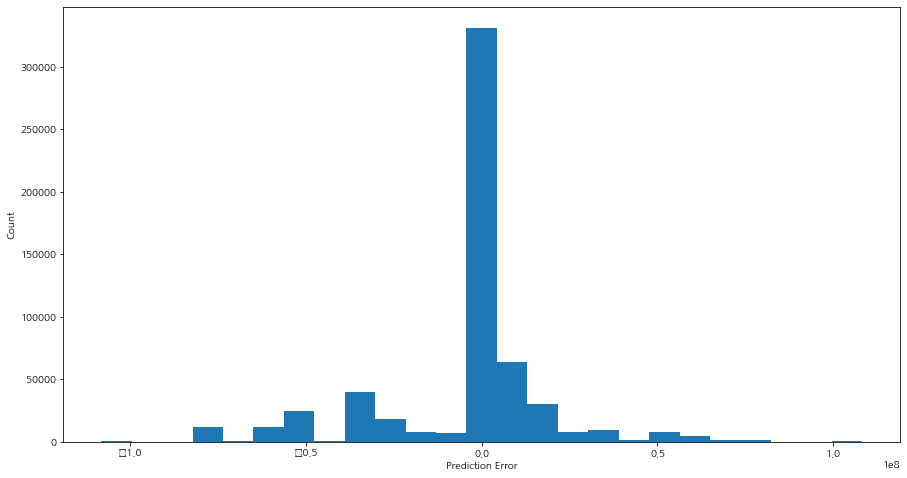

In [437]:
show_prediction_error(test_y, pred_xgb)

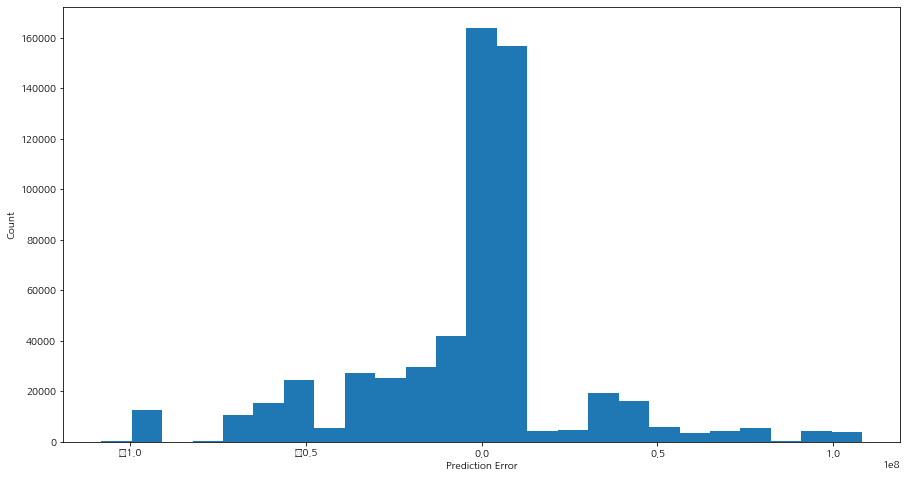

In [438]:
show_prediction_error(test_y, pred_lgbm)

In [ ]:
feature_series = pd.Series(data=model_xgb.feature_importances_, index=train_X.columns)
feature_series = feature_series.sort_values(ascending=False) 
sns.barplot(x = feature_series, y=feature_series.index)

In [ ]:
feature_series = pd.Series(data=model_lgbm.feature_importances_, index=train_X.columns)
feature_series = feature_series.sort_values(ascending=False) 
sns.barplot(x = feature_series, y=feature_series.index)